In [156]:
!pip install openpyxl xlrd xlwt dvipng

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
ERROR: Could not find a version that satisfies the requirement dvipng (from versions: none)
ERROR: No matching distribution found for dvipng


# Vasicek Model (Brigo-Mercurio 3.2.1(2006))

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
kko = fm.FontProperties(fname='./Kakao-bRg.ttf',size='xx-large')
mlgn = fm.FontProperties(fname='./malgun.ttf',size='xx-large')

In [5]:
df_spread = pd.read_excel('./rawdata.xls', sheet_name='Data')
df_spread = df_spread.rename(columns={'Dates':'date'}).fillna(method='ffill')
df_spread['date_desc'] = df_spread.sort_values(['date'], ascending=[False]).groupby(df_spread['date'].dt.strftime('%Y-%m')).cumcount() + 1
df_spread = df_spread[df_spread['date_desc'] == 1]
# df_spread = df_spread[df_spread['date'].dt.day_name()=='Friday']
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(df_spread)
print(df_spread.columns)
df_spread.iloc[:,1:10] *= 100
print(df_spread)
for i in range(1,10):
    df_spread['lagged '+df_spread.columns[i]] = df_spread[df_spread.columns[i]].shift(1)
# df_spread['lagged Euro Corporate'] = df_spread['Euro Corporate'].shift(1)

cols, rows = df_spread.shape
print(cols, rows)
n = cols - 1
d = 1/12

Index(['date', 'Euro Corporate', 'Euro Financials', 'Euro Industrials',
       'Euro Utilities', 'Euro Covered', 'Euro Corporate Aaa',
       'Euro Corporate Aa', 'Euro Corporate A', 'Euro Corporate Baa ',
       'date_desc'],
      dtype='object')
           date  Euro Corporate  Euro Financials  Euro Industrials  \
21   2006-01-31         44.5677          37.4385           56.1217   
41   2006-02-28         45.3083          37.0624           57.9979   
64   2006-03-31         46.9694          40.2067           57.4706   
84   2006-04-28         45.3228          39.6582           54.2983   
107  2006-05-31         48.3061          42.3042           58.4042   
...         ...             ...              ...               ...   
4020 2021-05-31         84.5654          90.1528           80.3569   
4042 2021-06-30         82.0689          87.2376           77.9773   
4064 2021-07-30         82.8720          88.3942           78.3224   
4086 2021-08-31         83.6435          88.2026   

In [6]:
col_eucorp = df_spread.columns.get_loc('Euro Corporate')
col_eucorp_lag = df_spread.columns.get_loc('lagged Euro Corporate')
sum_eucorp_paced = df_spread.iloc[1:cols,col_eucorp].sum()
mean_eucorp_paced = df_spread.iloc[1:cols,col_eucorp].mean()
sum_eucorp_lagged = df_spread.iloc[1:cols,col_eucorp_lag].sum()
sum_eucorp_lagged_squares = (df_spread.iloc[1:cols,col_eucorp_lag]**2).sum()
sum_eucorp_paced_lagged = (df_spread.iloc[1:cols,col_eucorp]*df_spread.iloc[1:cols,col_eucorp_lag]).sum()
alpha_hat_eucorp = (n * sum_eucorp_paced_lagged - sum_eucorp_paced * sum_eucorp_lagged) / (n * sum_eucorp_lagged_squares - sum_eucorp_lagged ** 2)
beta_hat_eucorp = (sum_eucorp_paced - alpha_hat_eucorp * sum_eucorp_lagged) / (n * (1 - alpha_hat_eucorp))
v_square_hat = 1/n * ((df_spread.iloc[1:cols,col_eucorp] - alpha_hat_eucorp * df_spread.iloc[1:cols,col_eucorp] - beta_hat_eucorp * (1 - alpha_hat_eucorp)) ** 2).sum()
a = np.log(alpha_hat_eucorp)/(-d)
b = beta_hat_eucorp * a
sigma_eucorp = np.sqrt(2 * a * v_square_hat/(1-alpha_hat_eucorp**2))
kappa_eucorp = a
theta_eucorp = beta_hat_eucorp
print(f'{df_spread.columns[col_eucorp]}) mean from data: {mean_eucorp_paced:.4f}')
print(f'{df_spread.columns[col_eucorp]}) mean-reversion speed: {kappa_eucorp:.4f}, long-term mean: {theta_eucorp:.4f}, volatility: {sigma_eucorp:.4f}')

Euro Corporate) mean from data: 147.7657
Euro Corporate) mean-reversion speed: 0.5500, long-term mean: 152.0630, volatility: 13.5629


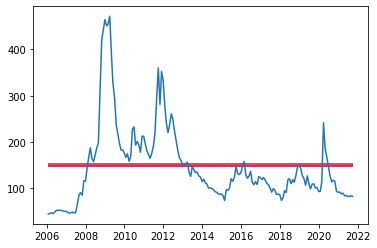

In [7]:
import matplotlib.pyplot as plt
plt.plot(df_spread['date'], df_spread.iloc[:,col_eucorp])
plt.hlines(mean_eucorp_paced, xmin=min(df_spread['date']), xmax=max(df_spread['date']), colors='purple')
plt.hlines(theta_eucorp, xmin=min(df_spread['date']), xmax=max(df_spread['date']), colors='red')
plt.show()

In [114]:
eu = [[],[]]
for wdw in range(1, cols):
    n = cols - wdw
    col_eucorp = df_spread.columns.get_loc('Euro Corporate')
    col_eucorp_lag = df_spread.columns.get_loc('lagged Euro Corporate')
    sum_eucorp_paced = df_spread.iloc[wdw:cols,col_eucorp].sum()
    mean_eucorp_paced = df_spread.iloc[wdw:cols,col_eucorp].mean()
    sum_eucorp_lagged = df_spread.iloc[wdw:cols,col_eucorp_lag].sum()
    sum_eucorp_lagged_squares = (df_spread.iloc[wdw:cols,col_eucorp_lag]**2).sum()
    sum_eucorp_paced_lagged = (df_spread.iloc[wdw:cols,col_eucorp]*df_spread.iloc[wdw:cols,col_eucorp_lag]).sum()
    alpha_hat_eucorp = (n * sum_eucorp_paced_lagged - sum_eucorp_paced * sum_eucorp_lagged) / (n * sum_eucorp_lagged_squares - sum_eucorp_lagged ** 2)
    beta_hat_eucorp = (sum_eucorp_paced - alpha_hat_eucorp * sum_eucorp_lagged) / (n * (1 - alpha_hat_eucorp))
    v_square_hat = 1/n * ((df_spread.iloc[1:cols,col_eucorp] - alpha_hat_eucorp * df_spread.iloc[1:cols,col_eucorp] - beta_hat_eucorp * (1 - alpha_hat_eucorp)) ** 2).sum()
    a = np.log(alpha_hat_eucorp)/(-d)
    b = beta_hat_eucorp * a
    sigma_eucorp = np.sqrt(2 * a * v_square_hat/(1-alpha_hat_eucorp**2))
    kappa_eucorp = a
    theta_eucorp = beta_hat_eucorp
    eucorp[0].append(theta_eucorp)
    eucorp[1].append(mean_eucorp_paced)
# print(f'{df_spread.columns[col_eucorp]}) mean from data: {mean_eucorp_paced:.4f}')
# print(f'{df_spread.columns[col_eucorp]}) mean-reversion speed: {kappa_eucorp:.4f}, long-term mean: {theta_eucorp:.4f}, volatility: {sigma_eucorp:.4f}')

/var/folders/nj/d0q4cgls0973y2xqcdpb7h4r0000gn/T/ipykernel_5622/994703589.py:14: RuntimeWarning: invalid value encountered in log
  a = np.log(alpha_hat_eucorp)/(-d)
/var/folders/nj/d0q4cgls0973y2xqcdpb7h4r0000gn/T/ipykernel_5622/994703589.py:11: RuntimeWarning: invalid value encountered in double_scalars
  alpha_hat_eucorp = (n * sum_eucorp_paced_lagged - sum_eucorp_paced * sum_eucorp_lagged) / (n * sum_eucorp_lagged_squares - sum_eucorp_lagged ** 2)


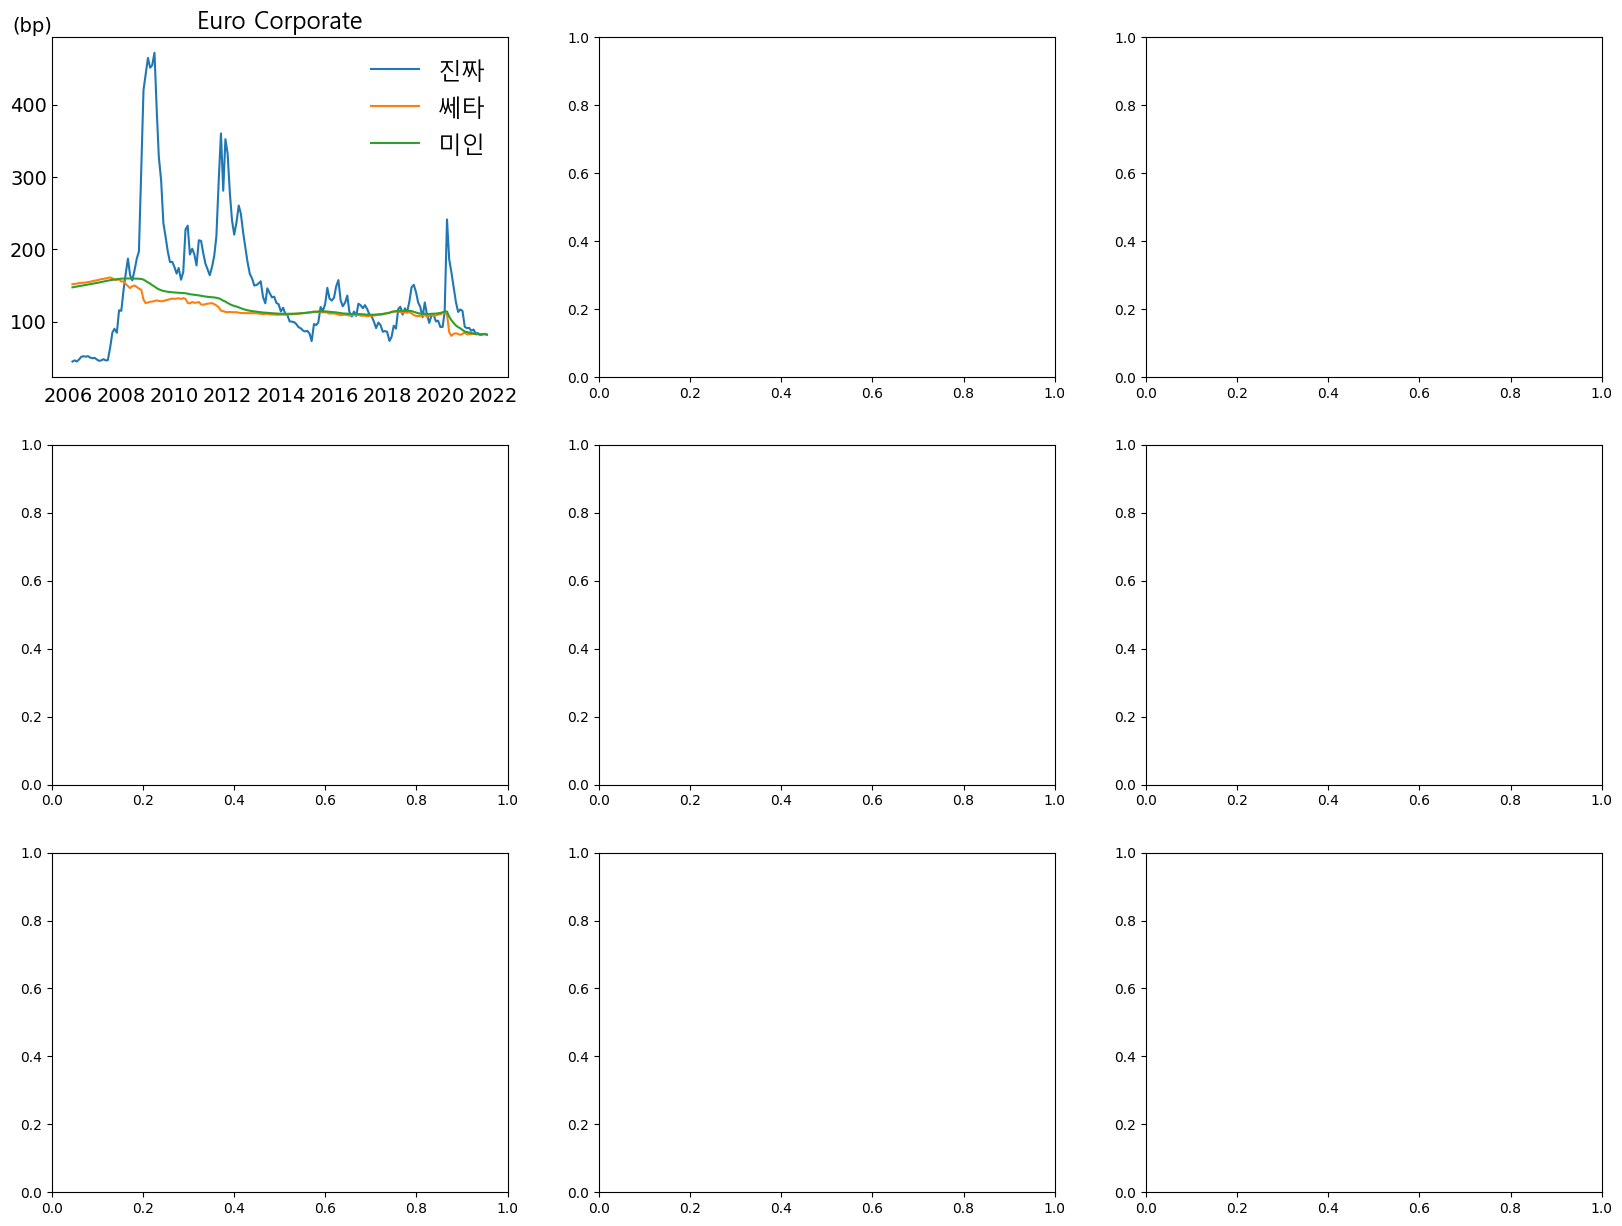

In [174]:
import matplotlib.pyplot as plt

fontsize=14
date2num = mpl.dates.date2num(df_spread['date'])
mpl.rcParams.update(mpl.rcParamsDefault)
fig, axs = plt.subplots(3, 3, figsize=(20,15))

axs[0, 0].set_title(df_spread.columns[col_eucorp], fontsize=fontsize, font=mlgn)
axs[0, 0].plot(df_spread['date'][1:cols], df_spread.iloc[1:cols,col_eucorp], label='진짜')
axs[0, 0].plot(df_spread['date'][1:cols], eucorp[0], label='쎄타')
axs[0, 0].plot(df_spread['date'][1:cols], eucorp[1], label='미인')
axs[0, 0].tick_params(axis='x', bottom=False, labelsize=fontsize)
axs[0, 0].tick_params(axis='y', direction='in', labelsize=fontsize)
axs[0, 0].legend(loc='best',frameon=False, prop=mlgn)
axs[0, 0].text(date2num[0] - 800, 500, '(bp)', fontsize=fontsize)

plt.show()

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
kko = fm.FontProperties(fname='./Kakao-bRg.ttf',size='xx-large')
mlgn = fm.FontProperties(fname='./malgun.ttf',size='xx-large')

df_spread = pd.read_excel('./rawdata.xls', sheet_name='Data')
df_spread = df_spread.rename(columns={'Dates':'date'}).fillna(method='ffill')
df_spread['date_desc'] = df_spread.sort_values(['date'], ascending=[False]).groupby(df_spread['date'].dt.strftime('%Y-%m')).cumcount() + 1
df_spread = df_spread[df_spread['date_desc'] == 1]
# df_spread = df_spread[df_spread['date'].dt.day_name()=='Friday']
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(df_spread)
print(df_spread.columns)
df_spread.iloc[:,1:10] *= 100
# print(df_spread)
for i in range(1,10):
    df_spread['lagged '+df_spread.columns[i]] = df_spread[df_spread.columns[i]].shift(1)
# df_spread['lagged Euro Corporate'] = df_spread['Euro Corporate'].shift(1)

cols, rows = df_spread.shape
print(cols, rows)
n = cols - 1
d = 1/12

eu = np.zeros((cols - 1, 4, 9))
print(len(eu))
for i in range(9):
    for wdw in range(1, cols):
        n = cols - wdw
        col_eu = i+1 # df_spread.columns.get_loc('Euro Corporate')
        col_eu_lag = i+11 # df_spread.columns.get_loc('lagged Euro Corporate')
        sum_eu_paced = df_spread.iloc[wdw:cols,col_eu].sum()
        mean_eu_paced = df_spread.iloc[wdw:cols,col_eu].mean()
        sum_eu_lagged = df_spread.iloc[wdw:cols,col_eu_lag].sum()
        sum_eu_lagged_squares = (df_spread.iloc[wdw:cols,col_eu_lag]**2).sum()
        sum_eu_paced_lagged = (df_spread.iloc[wdw:cols,col_eu]*df_spread.iloc[wdw:cols,col_eu_lag]).sum()
        alpha_hat_eu = (n * sum_eu_paced_lagged - sum_eu_paced * sum_eu_lagged) / (n * sum_eu_lagged_squares - sum_eu_lagged ** 2)
        beta_hat_eu = (sum_eu_paced - alpha_hat_eu * sum_eu_lagged) / (n * (1 - alpha_hat_eu))
        v_square_hat = 1/n * ((df_spread.iloc[1:cols,col_eu] - alpha_hat_eu * df_spread.iloc[1:cols,col_eu] - beta_hat_eu * (1 - alpha_hat_eu)) ** 2).sum()
        a = np.log(alpha_hat_eu)/(-d)
        b = beta_hat_eu * a
        sigma_eu = np.sqrt(2 * a * v_square_hat/(1-alpha_hat_eu**2))
        kappa_eu = a
        theta_eu = beta_hat_eu
        eu[wdw-1,0,i]=theta_eu
        eu[wdw-1,1,i]=mean_eu_paced
        eu[wdw-1,2,i]=kappa_eu
        eu[wdw-1,3,i]=sigma_eu      

Index(['date', 'Euro Corporate', 'Euro Financials', 'Euro Industrials',
       'Euro Utilities', 'Euro Covered', 'Euro Corporate Aaa',
       'Euro Corporate Aa', 'Euro Corporate A', 'Euro Corporate Baa ',
       'date_desc'],
      dtype='object')
189 20
188


/var/folders/nj/d0q4cgls0973y2xqcdpb7h4r0000gn/T/ipykernel_4102/2434725775.py:44: RuntimeWarning: invalid value encountered in log
  a = np.log(alpha_hat_eu)/(-d)
/var/folders/nj/d0q4cgls0973y2xqcdpb7h4r0000gn/T/ipykernel_4102/2434725775.py:41: RuntimeWarning: invalid value encountered in double_scalars
  alpha_hat_eu = (n * sum_eu_paced_lagged - sum_eu_paced * sum_eu_lagged) / (n * sum_eu_lagged_squares - sum_eu_lagged ** 2)


In [17]:
print(eu[-1,1,0])        

82.4582


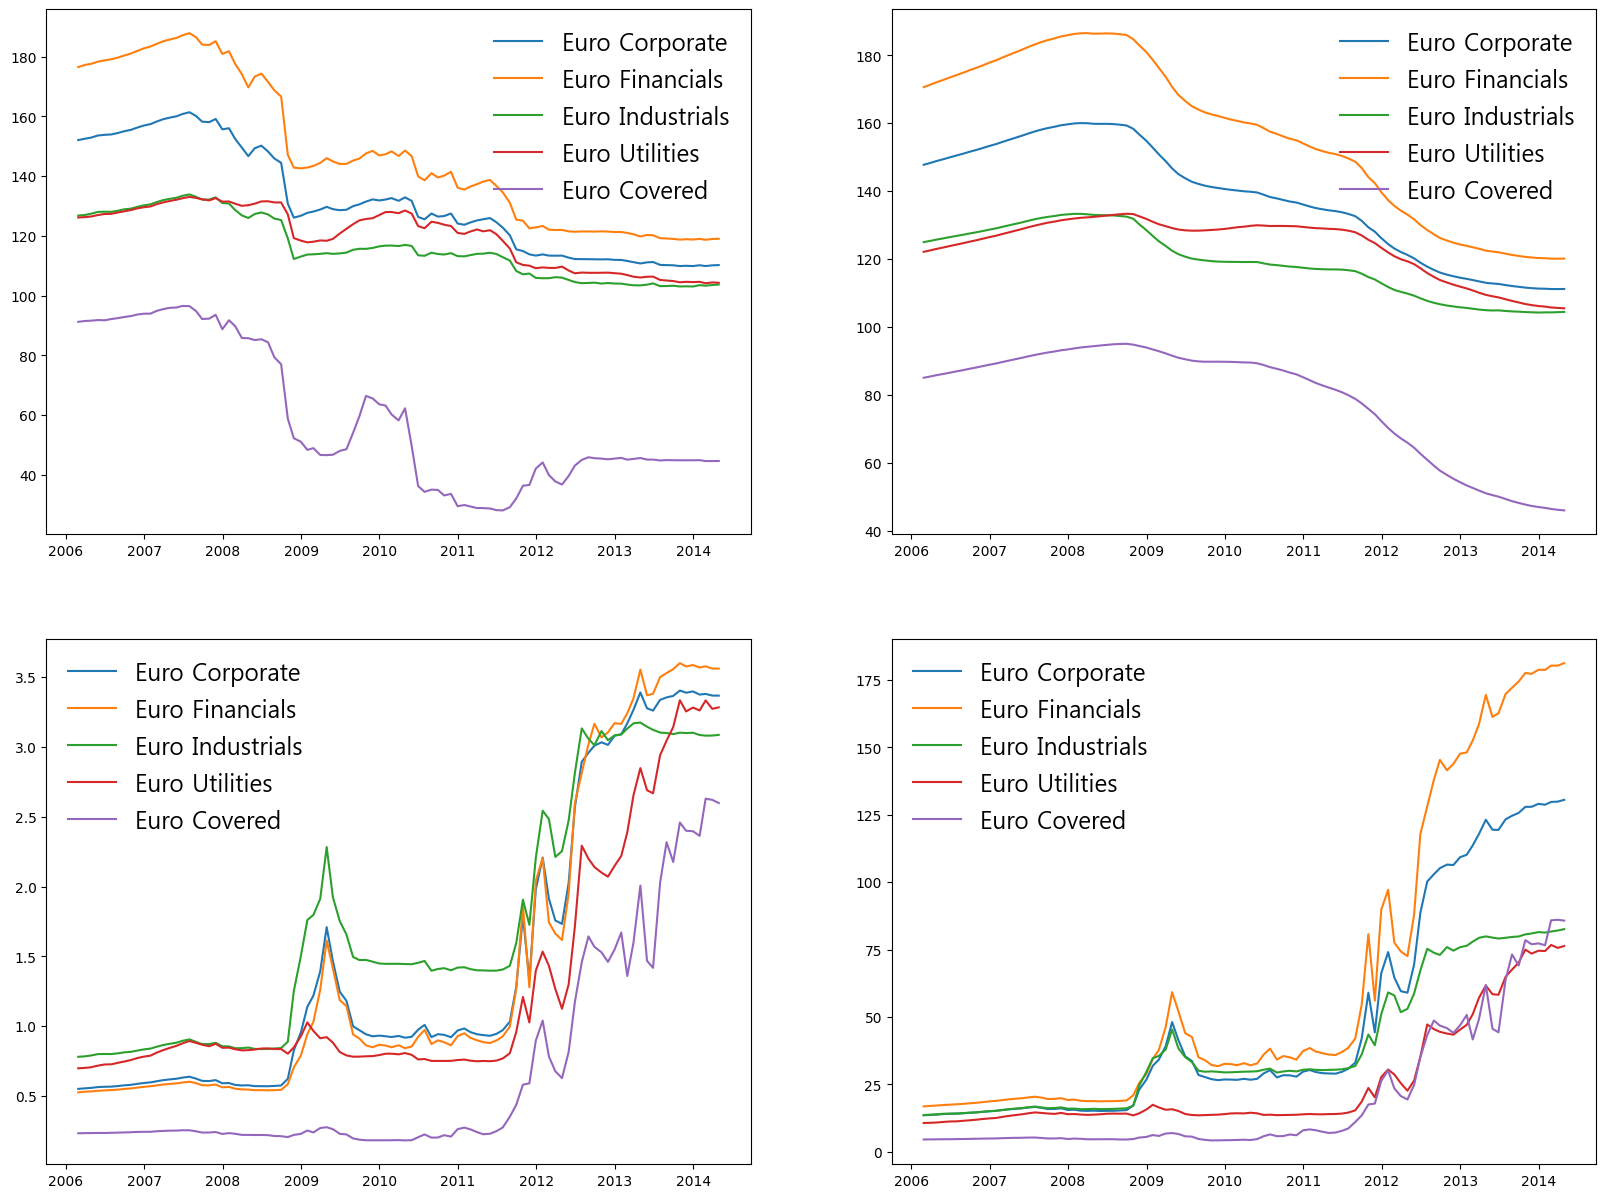

In [43]:
import matplotlib.pyplot as plt

fontsize=14
date2num = mpl.dates.date2num(df_spread['date'])
mpl.rcParams.update(mpl.rcParamsDefault)
fig, axs = plt.subplots(2, 2, figsize=(20,15))
for i in range(4):
    for j in range(5):
        axs[i//2, i%2].plot(df_spread['date'][1:100], eu[:99,i,j], label=df_spread.columns[j+1])
    axs[i//2, i%2].legend(loc='best',frameon=False, prop=mlgn)
plt.show()

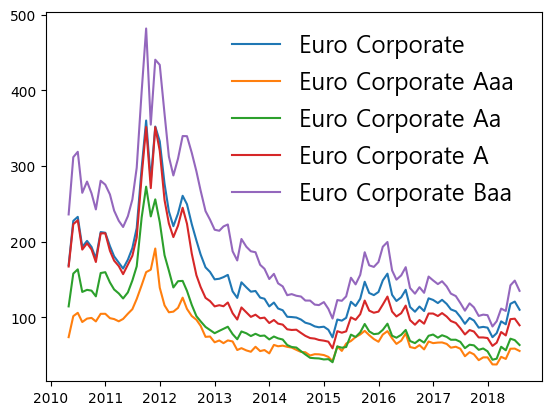

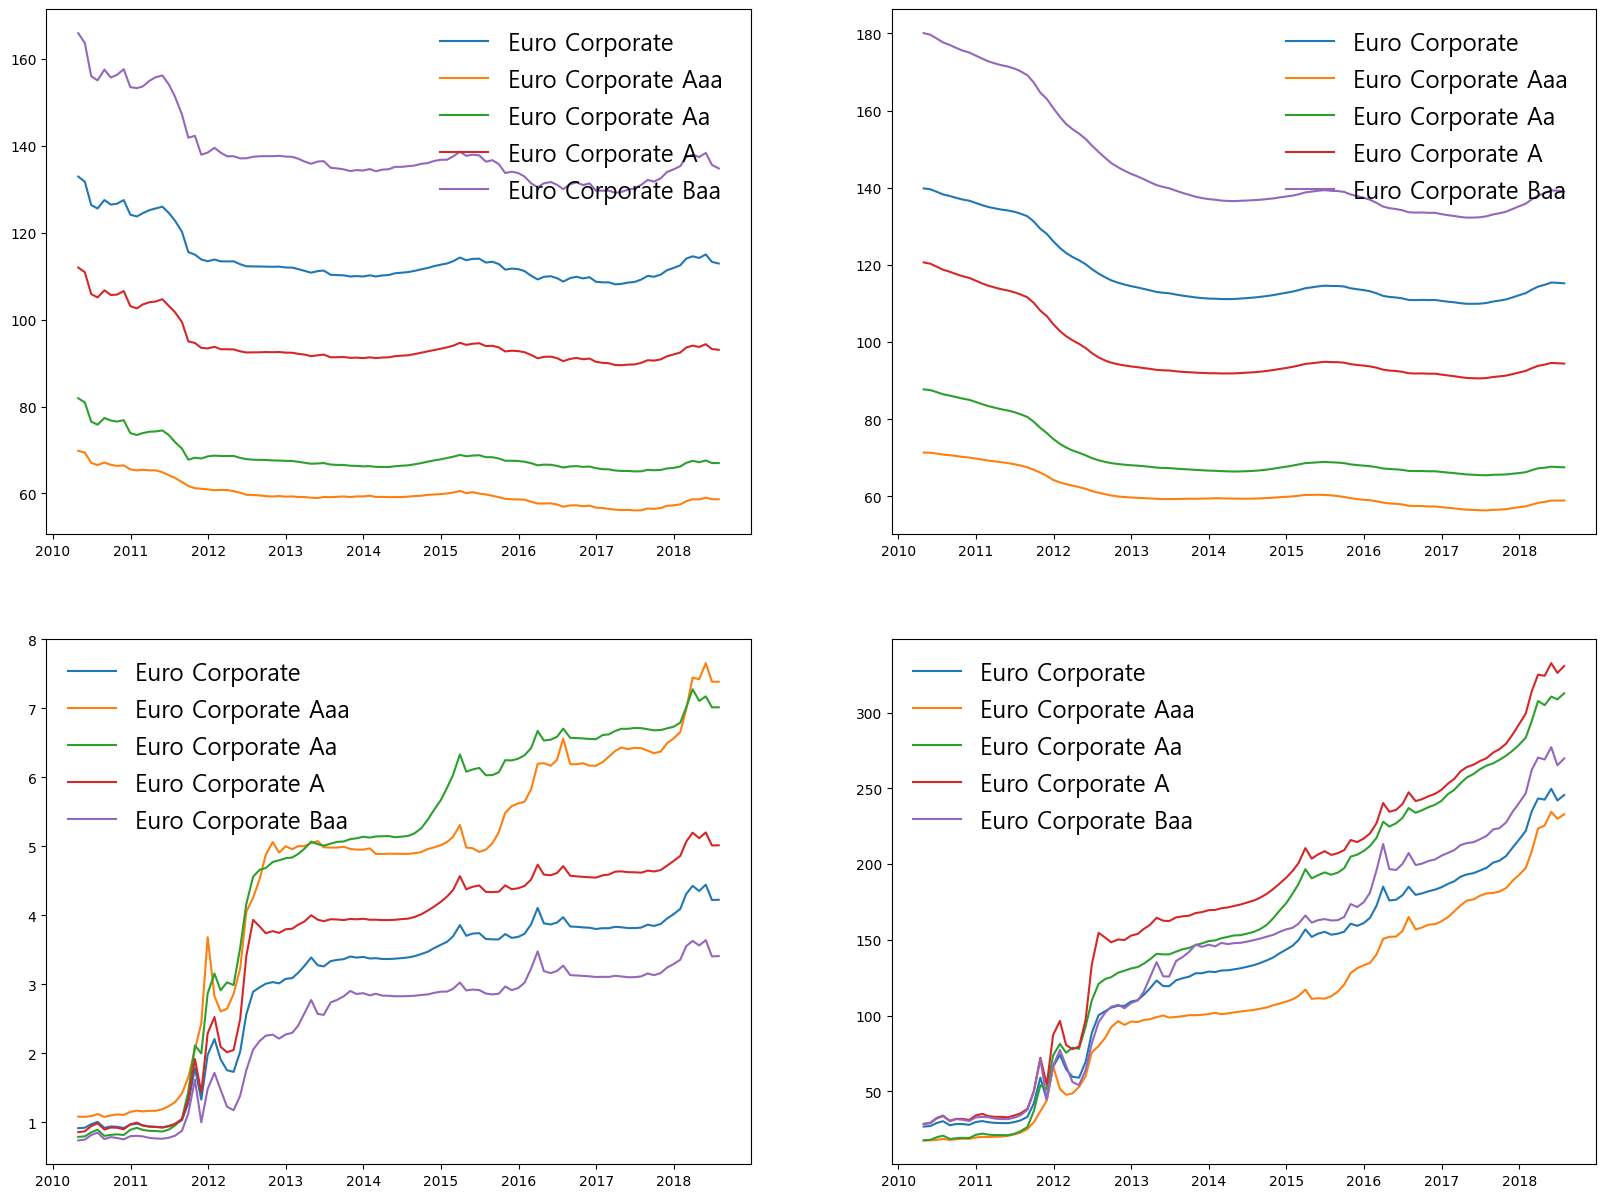

In [5]:
import matplotlib.pyplot as plt

fontsize=14
date2num = mpl.dates.date2num(df_spread['date'])
mpl.rcParams.update(mpl.rcParamsDefault)
fig, axs = plt.subplots(1, 1)
for j in [0, 5, 6, 7, 8]:
    axs.plot(df_spread['date'][51:151], df_spread.iloc[51:151,j+1], label=df_spread.columns[j+1])
axs.legend(loc='best',frameon=False, prop=mlgn)    
fig, axs = plt.subplots(2, 2, figsize=(20,15))
for i in range(4):
    for j in [0, 5, 6, 7, 8]:
        axs[i//2, i%2].plot(df_spread['date'][51:151], eu[50:150,i,j], label=df_spread.columns[j+1])
    axs[i//2, i%2].legend(loc='best',frameon=False, prop=mlgn)

plt.show()